#**Pre-request**

##Mount google drive


In [1]:
### **Mount** Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install pakages


In [2]:
#Install pakages
project_path = "/content/drive/MyDrive/Sem-6/coding/github/fraud_detection/"
!cat "{project_path}requirement/Install/ML_Advance_requirements.txt"
#%pip install -q -r /content/drive/MyDrive/Sem-6/coding/github/fraud_detection/ML_requirements.txt --no-cache-dir
!pip install -q -r "{project_path}requirement/Install/ML_Advance_requirements.txt" --no-cache-dir




mamba-ssm
einops
transformers
causal-conv1d
kernels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 256.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.0 MB/s eta 0:00:00


In [3]:
%cd $project_path
%ls $project_path

/content/drive/MyDrive/Sem-6/coding/github/fraud_detection
configs/       ML_requirements-lock.txt  results/           tests/
dataset/       notebooks/                run_experiment.py
Informer2020/  README.md                 splits/
lib/           requirement/              src/


##Import  libs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import logging
import datetime
from google.colab import data_table
data_table.enable_dataframe_formatter()
# Expand Colab’s table display limits
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    recall_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, recall_score
import shap
from mamba_ssm import Mamba
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModel


In [5]:
!nvidia-smi                # confirm GPU
!pip show torch mamba-ssm  # confirm versions
torch.manual_seed(42)


Sat Nov  8 06:40:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#

##Config

In [6]:

logger = logging.getLogger(__name__)

def load_config(config_path="configs/baseline.yaml"):
    """Load YAML config file and expand ${root_path} placeholders."""
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    logger.info(f"✅ Loaded config from {config_path}")

    # --- Expand ${root_path} placeholders ---
    root = config.get("root_path", "")

    def expand_paths(obj):
        if isinstance(obj, dict):
            return {k: expand_paths(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [expand_paths(i) for i in obj]
        elif isinstance(obj, str) and "${root_path}" in obj:
            return obj.replace("${root_path}", root)
        else:
            return obj

    config = expand_paths(config)
    return config


#ML Modules

##Snapshot based

###Load snapshots

In [7]:

config = load_config(os.path.join(project_path, "configs", "baseline.yaml"))

snapshot_path = config['ML']['snapshot_input'] + config['ML']['snapshot_file']
df = pd.read_csv(snapshot_path)

print(f"✅ Loaded snapshot dataset: {df.shape}")



✅ Loaded snapshot dataset: (586685, 33)


##Split users level

In [8]:

user_path = config['ML']['Events']['base_path'] + config['ML']['Events']['files']['user']
df_user = pd.read_csv(user_path)
print(f"✅ Loaded transactional user dataset: {df_user.shape}")



# Aggregate to one row per user (max label = 1 if any fraud)
user_labels = df_user.groupby("phone_no_m")["label"].max()
print(f"👥 Unique users for splitting: {len(user_labels)}")

# ==============================================================
# 2️⃣ Create user-level split (stratified, no leakage)
# ==============================================================

fraud_users = user_labels[user_labels == 1].index
normal_users = user_labels[user_labels == 0].index

fraud_train, fraud_test = train_test_split(fraud_users, test_size=0.2, random_state=42)
normal_train, normal_test = train_test_split(normal_users, test_size=0.2, random_state=42)

train_users = set(fraud_train) | set(normal_train)
test_users  = set(fraud_test)  | set(normal_test)

# ==============================================================
# 3️⃣ Save unified split (shared across LSTM / RF / XGB)
# ==============================================================

split_dir = "splits"
os.makedirs(split_dir, exist_ok=True)

pd.DataFrame({"phone_no_m": sorted(train_users)}).to_csv(f"{split_dir}/train_users.csv", index=False)
pd.DataFrame({"phone_no_m": sorted(test_users)}).to_csv(f"{split_dir}/test_users.csv", index=False)

# ==============================================================
# 4️⃣ Summary
# ==============================================================

print("\n👥 Users Summary:")
print(f"   Total : {len(user_labels):,}")
print(f"   Fraud : {len(fraud_users):,} ({len(fraud_users)/len(user_labels)*100:.2f}%)")
print(f"   Normal: {len(normal_users):,} ({len(normal_users)/len(user_labels)*100:.2f}%)")

print("\n📂 Split saved to /splits/:")
print(f"   Train users: {len(train_users)}")
print(f"   Test  users: {len(test_users)}")
print(f"   Fraud ratio train: {len(fraud_train)/len(train_users)*100:.2f}%")
print(f"   Fraud ratio test : {len(fraud_test)/len(test_users)*100:.2f}%")


✅ Loaded transactional user dataset: (39454, 10)
👥 Unique users for splitting: 5929

👥 Users Summary:
   Total : 5,929
   Fraud : 1,788 (30.16%)
   Normal: 4,141 (69.84%)

📂 Split saved to /splits/:
   Train users: 4742
   Test  users: 1187
   Fraud ratio train: 30.16%
   Fraud ratio test : 30.16%


###drop colums

In [9]:
def prepare_features(df):
    """
    Selects only the explicitly defined features for model training.
    You control which features are used by editing 'selected_features' below.
    """

    # --- Define selected features manually ---
    selected_features = [
        "window_size", "voc_total_calls", "voc_unique_contacts", "voc_total_duration",
       "voc_avg_duration", "voc_max_duration", "voc_std_duration", "voc_active_days",
       "voc_active_hours", "sms_total_msgs", "sms_unique_contacts", "sms_active_hours",
       "sms_calltype_ratio", "app_months_active", "app_total_flow", "app_avg_flow",
       "app_std_flow", "app_unique_apps_mean", "app_unique_apps_max", "user_months_active",
        "arpu_mean", "arpu_std", "arpu_max", "idcard_cnt", "snapshot_round"
   ]
  #  selected_features = [
   #     "voc_total_calls", "voc_unique_contacts", "voc_total_duration",
    #   "voc_avg_duration", "voc_max_duration", "voc_std_duration", "voc_active_days",
     # "voc_active_hours", "sms_total_msgs", "sms_unique_contacts", "sms_active_hours",
     #"sms_calltype_ratio", "idcard_cnt"
    #]
   # selected_features = [
    #    "voc_active_days",
    #"voc_active_hours",
    #"voc_unique_contacts",
    #"sms_calltype_ratio",
    #"sms_active_hours" ]


    # ✅ You can manually remove or comment out features here
    # For example:
    # selected_features = [f for f in selected_features if not (f.startswith("app_") or f.startswith("arpu_"))]

    # --- Keep only existing columns ---
    available = [f for f in selected_features if f in df.columns]
    missing = [f for f in selected_features if f not in df.columns]

    X = df[available].copy()

    print(f"\n📊 Final features used ({len(available)}): {available}")
    if missing:
        print(f"⚠️ Missing columns not found in data: {missing}")

    return X


###Split for snapshot based

In [10]:


# ==============================================================
# 1️⃣ Load or Create Unified User Split
# ==============================================================

split_dir = "splits"
train_split_file = f"{split_dir}/train_users.csv"
test_split_file  = f"{split_dir}/test_users.csv"

if os.path.exists(train_split_file) and os.path.exists(test_split_file):
    print("📂 Using existing user split from file...")
    train_users = set(pd.read_csv(train_split_file)["phone_no_m"])
    test_users  = set(pd.read_csv(test_split_file)["phone_no_m"])
else:
    print("🆕 Creating new unified user split...")
    os.makedirs(split_dir, exist_ok=True)

    user_labels = df.groupby("phone_no_m")["label"].max()
    fraud_users  = user_labels[user_labels == 1].index
    normal_users = user_labels[user_labels == 0].index

    fraud_train, fraud_test = train_test_split(fraud_users, test_size=0.2, random_state=42)
    normal_train, normal_test = train_test_split(normal_users, test_size=0.2, random_state=42)

    train_users = set(fraud_train) | set(normal_train)
    test_users  = set(fraud_test)  | set(normal_test)

    pd.DataFrame({"phone_no_m": sorted(train_users)}).to_csv(train_split_file, index=False)
    pd.DataFrame({"phone_no_m": sorted(test_users)}).to_csv(test_split_file, index=False)
    print(f"✅ Saved user split to '{split_dir}/'")

print(f"✅ Train users: {len(train_users)} | Test users: {len(test_users)}")

# ==============================================================
# 2️⃣ Apply User Split to Snapshot Data
# ==============================================================

train_df = df[df["phone_no_m"].isin(train_users)]
test_df  = df[df["phone_no_m"].isin(test_users)]

assert len(set(train_df["phone_no_m"]) & set(test_df["phone_no_m"])) == 0, "❌ User leakage detected!"
assert train_df["label"].nunique() == 2, "❌ Training set must contain both classes"
assert test_df["label"].nunique() == 2, "❌ Test set must contain both classes"

print(f"\n👥 User Summary:")
print(f"   Train users: {len(train_users):,}")
print(f"   Test  users: {len(test_users):,}")

print(f"\n📊 Event Split Summary:")
for name, df_part in [("Train", train_df), ("Test", test_df)]:
    total = len(df_part)
    fraud = df_part["label"].sum()
    print(f"   {name:5s} → {total:,} snapshots | Fraud: {fraud/total*100:.2f}% | Normal: {(1 - fraud/total)*100:.2f}%")

# ==============================================================
# 3️⃣ Feature Preparation
# ==============================================================



# Case 1: include app* and arpu* columns
X_train = prepare_features(train_df)
X_test  = prepare_features(test_df)


# Case 2: exclude app* and arpu* columns
# X_train = prepare_features(train_df, use_app_arpu=False)
# X_test  = prepare_features(test_df, use_app_arpu=False)


# Align features (ensure same structure)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

y_train = train_df["label"].astype(int)
y_test  = test_df["label"].astype(int)

# ==============================================================
# 4️⃣ Full Dataset Scan + Scaling
# ==============================================================

# Combine all snapshots (for robust scaling reference)
all_data = pd.concat([train_df, test_df], axis=0)
print(f"\n📦 Scanning full dataset for scaling — total rows: {len(all_data):,}, columns: {len(all_data.columns)}")

numeric_cols = X_train.columns  # only use columns actually selected for the model
summary = all_data[numeric_cols].describe().T


# Select columns to scale (exclude binary or constants)
scale_cols = [
    c for c in numeric_cols
    if (summary.loc[c, "max"] - summary.loc[c, "min"]) > 5 and summary.loc[c, "max"] > 1
]
scale_cols = [c for c in scale_cols if c in X_train.columns]

print("\n📊 Numeric feature summary (before scaling):")
print(summary[["min", "max", "mean"]].round(2).sort_values("max", ascending=False))

print("\n📏 Selected for scaling (auto-detected based on range):")
print(scale_cols)

# Apply scaling
scaler = RobustScaler().fit(all_data[scale_cols])
X_train[scale_cols] = scaler.transform(X_train[scale_cols])
X_test[scale_cols]  = scaler.transform(X_test[scale_cols])

print("\n✅ Scaled snapshot features successfully.")
print(f"   Scaled columns: {len(scale_cols)} of {X_train.shape[1]} total features.")

# ==============================================================
# 5️⃣ Final Sanity Checks
# ==============================================================

print("\n✅ Feature Matrices Ready:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_test : {X_test.shape}, y_test : {y_test.shape}")

print("\n🔒 Consistency Check: ✅ Same users used for all models (LSTM, RF, XGBoost).")


📂 Using existing user split from file...
✅ Train users: 4742 | Test users: 1187

👥 User Summary:
   Train users: 4,742
   Test  users: 1,187

📊 Event Split Summary:
   Train → 469,307 snapshots | Fraud: 29.70% | Normal: 70.30%
   Test  → 117,378 snapshots | Fraud: 29.67% | Normal: 70.33%

📊 Final features used (25): ['window_size', 'voc_total_calls', 'voc_unique_contacts', 'voc_total_duration', 'voc_avg_duration', 'voc_max_duration', 'voc_std_duration', 'voc_active_days', 'voc_active_hours', 'sms_total_msgs', 'sms_unique_contacts', 'sms_active_hours', 'sms_calltype_ratio', 'app_months_active', 'app_total_flow', 'app_avg_flow', 'app_std_flow', 'app_unique_apps_mean', 'app_unique_apps_max', 'user_months_active', 'arpu_mean', 'arpu_std', 'arpu_max', 'idcard_cnt', 'snapshot_round']

📊 Final features used (25): ['window_size', 'voc_total_calls', 'voc_unique_contacts', 'voc_total_duration', 'voc_avg_duration', 'voc_max_duration', 'voc_std_duration', 'voc_active_days', 'voc_active_hours', 'sm

###

###cor

📊 Correlation Matrix — Snapshot Features (XGBoost & RF)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


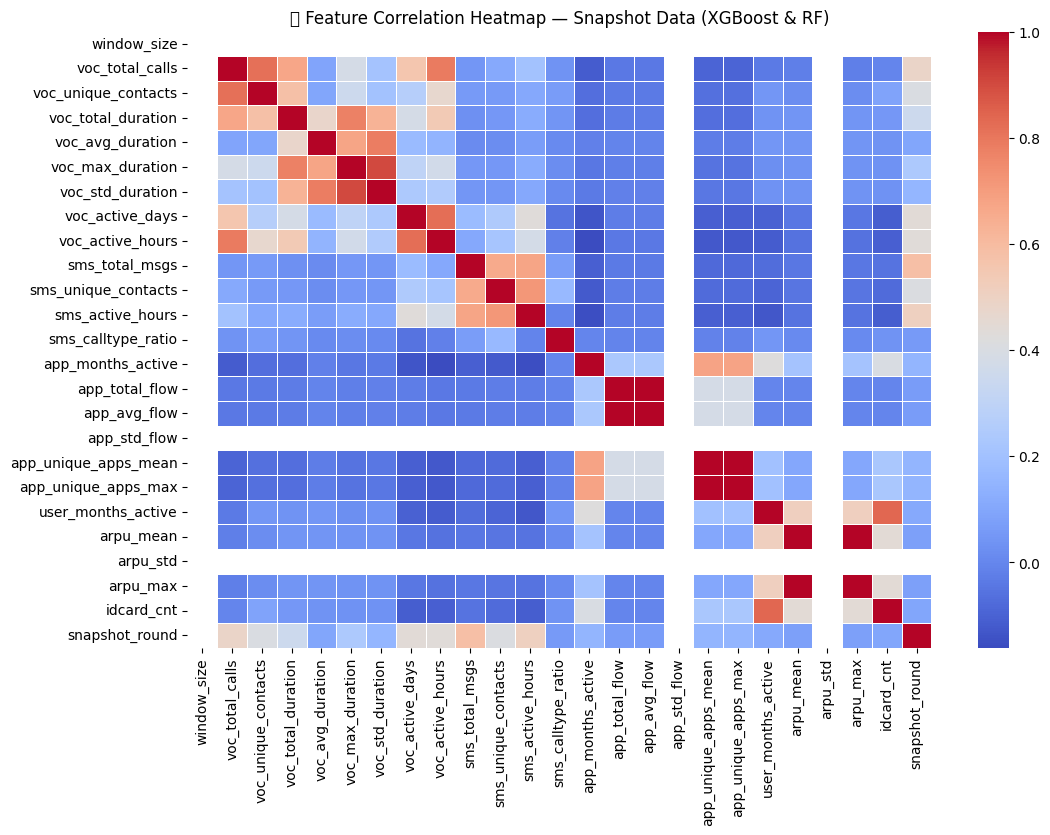

,Feature1,Feature2,Correlation
78,voc_max_duration,voc_std_duration,0.900456
195,app_total_flow,app_avg_flow,1.000000
210,app_unique_apps_mean,app_unique_apps_max,1.000000
225,arpu_mean,arpu_max,1.000000


In [11]:

# --- Snapshot correlation (XGBoost & RF) ---
print("📊 Correlation Matrix — Snapshot Features (XGBoost & RF)")

corr_snapshot = X_train.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_snapshot, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("📊 Feature Correlation Heatmap — Snapshot Data (XGBoost & RF)")
plt.show()

# Optional: List highly correlated pairs
threshold = 0.85
corr_pairs = (
    corr_snapshot.where(np.triu(np.ones(corr_snapshot.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_snapshot = corr_pairs[corr_pairs["Correlation"].abs() > threshold]
display(high_corr_snapshot)


###XGBoost

####Training

In [12]:

xgb_model  = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    scale_pos_weight=2.6,
    min_child_weight=1,
    gamma=0.1
    #--tree_method='gpu_hist',
    #--predictor='gpu_predictor'

)
print("🚀 Training XGBoost...")
xgb_model .fit(X_train, y_train)


🚀 Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

###RF

####Train

In [13]:
# ✅ Train Random Forest in parallel
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

print("🌲 Training Random Forest...")
rf_model.fit(X_train, y_train)





🌲 Training Random Forest...


RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

###Test

In [14]:

snapshot_indices = []
snapshot_metrics_xgb = []
snapshot_metrics_rf = []
recalls_xgb = []
recalls_rf = []
f1s_xgb, f1s_rf = [], []


for snap_idx, group in test_df.groupby('snapshot_index'):
    y_true = group['label']
    if y_true.nunique() < 2:
        continue

    X_snap = prepare_features(group)
    X_snap = X_snap.reindex(columns=X_train.columns, fill_value=0)

    # 🔹 XGBoost
    y_pred_xgb = xgb_model.predict_proba(X_snap)[:, 1]
    auc_xgb = roc_auc_score(y_true, y_pred_xgb)
    rec_xgb = recall_score(y_true, (y_pred_xgb > 0.5).astype(int))
    f1_xgb  = f1_score(y_true, (y_pred_xgb > 0.5).astype(int))


    # 🔹 Random Forest
    y_pred_rf = rf_model.predict_proba(X_snap)[:, 1]
    auc_rf = roc_auc_score(y_true, y_pred_rf)
    rec_rf = recall_score(y_true, (y_pred_rf > 0.5).astype(int))
    f1_rf  = f1_score(y_true, (y_pred_rf > 0.5).astype(int))


    # Append results
    snapshot_indices.append(snap_idx)
    snapshot_metrics_xgb.append(auc_xgb)
    snapshot_metrics_rf.append(auc_rf)
    recalls_xgb.append(rec_xgb)
    recalls_rf.append(rec_rf)
    f1s_xgb.append(f1_xgb)
    f1s_rf.append(f1_rf)



📊 Final features used (25): ['window_size', 'voc_total_calls', 'voc_unique_contacts', 'voc_total_duration', 'voc_avg_duration', 'voc_max_duration', 'voc_std_duration', 'voc_active_days', 'voc_active_hours', 'sms_total_msgs', 'sms_unique_contacts', 'sms_active_hours', 'sms_calltype_ratio', 'app_months_active', 'app_total_flow', 'app_avg_flow', 'app_std_flow', 'app_unique_apps_mean', 'app_unique_apps_max', 'user_months_active', 'arpu_mean', 'arpu_std', 'arpu_max', 'idcard_cnt', 'snapshot_round']

📊 Final features used (25): ['window_size', 'voc_total_calls', 'voc_unique_contacts', 'voc_total_duration', 'voc_avg_duration', 'voc_max_duration', 'voc_std_duration', 'voc_active_days', 'voc_active_hours', 'sms_total_msgs', 'sms_unique_contacts', 'sms_active_hours', 'sms_calltype_ratio', 'app_months_active', 'app_total_flow', 'app_avg_flow', 'app_std_flow', 'app_unique_apps_mean', 'app_unique_apps_max', 'user_months_active', 'arpu_mean', 'arpu_std', 'arpu_max', 'idcard_cnt', 'snapshot_round']


###Report

In [15]:

def evaluate_model_global(model, X_test, y_test, model_name="Model"):
    """
    Evaluate model on test data and display classification report + confusion matrix.
    """
    # Predict probabilities and labels
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Classification Report
    print(f"\n📊 Classification Report — {model_name}")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Fraud (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.grid(False)
    plt.show()

    return y_pred, y_pred_prob, cm

/tmp/ipython-input-1592524357.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


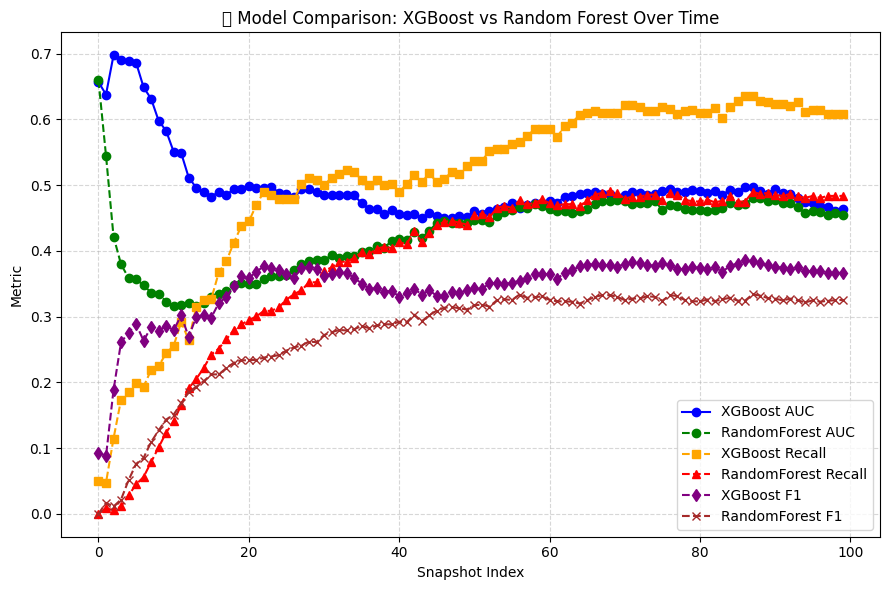


📊 Classification Report — XGBoost
              precision    recall  f1-score   support

           0     0.8796    0.8377    0.8581     82549
           1     0.6544    0.7282    0.6893     34829

    accuracy                         0.8052    117378
   macro avg     0.7670    0.7830    0.7737    117378
weighted avg     0.8128    0.8052    0.8080    117378



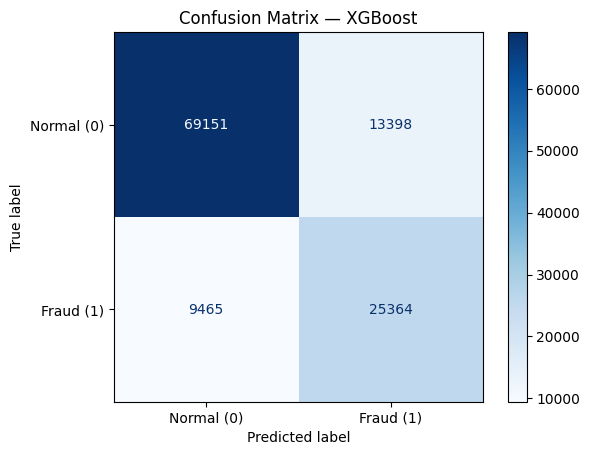


📊 Classification Report — Random Forest
              precision    recall  f1-score   support

           0     0.8401    0.9354    0.8852     82549
           1     0.7905    0.5780    0.6678     34829

    accuracy                         0.8293    117378
   macro avg     0.8153    0.7567    0.7765    117378
weighted avg     0.8254    0.8293    0.8207    117378



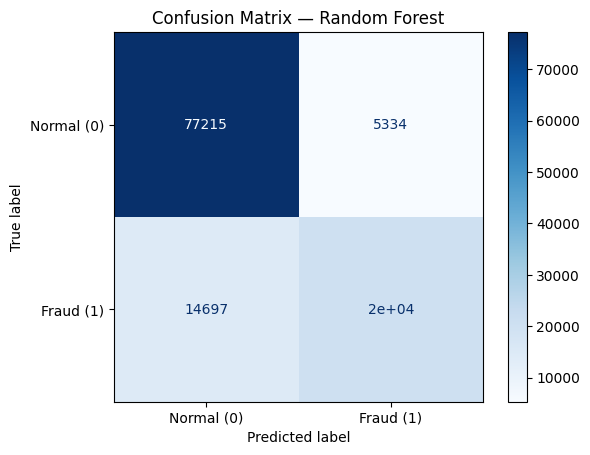


📋 Global Model Comparison Summary:


,Model,AUC,Recall,Precision,F1
0,XGBoost,0.850587,0.728244,0.654352,0.689323
1,Random Forest,0.848567,0.578024,0.790544,0.667783


In [16]:


plt.figure(figsize=(9,6))
plt.plot(snapshot_indices, snapshot_metrics_xgb, 'b-o', label='XGBoost AUC')
plt.plot(snapshot_indices, snapshot_metrics_rf, 'g--o', label='RandomForest AUC')
plt.plot(snapshot_indices, recalls_xgb, 'orange', marker='s', linestyle='--', label='XGBoost Recall')
plt.plot(snapshot_indices, recalls_rf, 'red', marker='^', linestyle='--', label='RandomForest Recall')
plt.plot(snapshot_indices, f1s_xgb, 'purple', marker='d', linestyle='--', label='XGBoost F1')
plt.plot(snapshot_indices, f1s_rf, 'brown', marker='x', linestyle='--', label='RandomForest F1')

plt.xlabel('Snapshot Index')
plt.ylabel('Metric')
plt.title('📊 Model Comparison: XGBoost vs Random Forest Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Evaluate XGBoost
y_pred_xgb, y_pred_prob_xgb, cm_xgb = evaluate_model_global(xgb_model, X_test, y_test, "XGBoost")

# Evaluate Random Forest
y_pred_rf, y_pred_prob_rf, cm_rf = evaluate_model_global(rf_model, X_test, y_test, "Random Forest")



summary = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest"],
    "AUC": [
        roc_auc_score(y_test, y_pred_prob_xgb),
        roc_auc_score(y_test, y_pred_prob_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_rf)
    ],
    "Precision": [
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision']
    ],
    "F1": [
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score']
    ]
})

print("\n📋 Global Model Comparison Summary:")
display(summary)



###importance

In [17]:
def plot_feature_importance(model, X_train, model_name="Model", top_n=20):
    """
    Plot feature importance for tree-based models (XGBoost, RandomForest).
    """


    # Handle model type
    if hasattr(model, "get_booster"):  # XGBoost
        importance = model.get_booster().get_score(importance_type='gain')
        fi = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        })
    elif hasattr(model, "feature_importances_"):  # RandomForest
        fi = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        })
    else:
        raise ValueError(f"{model_name} does not support feature importance extraction.")

    # Sort and plot
    fi = fi.sort_values(by='Importance', ascending=False)
    display(fi.head(10))

    plt.figure(figsize=(10,6))
    plt.barh(fi['Feature'][:top_n][::-1], fi['Importance'][:top_n][::-1])
    plt.title(f'📊 {model_name} Feature Importance (Top {top_n})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

    return fi


,Feature,Importance
6,voc_active_days,1535.689575
1,voc_unique_contacts,517.689575
7,voc_active_hours,436.701385
11,sms_calltype_ratio,241.712189
10,sms_active_hours,226.707016
9,sms_unique_contacts,168.624847
17,user_months_active,162.734177
22,snapshot_round,157.812653
0,voc_total_calls,146.126160
8,sms_total_msgs,140.631760


/tmp/ipython-input-3543811054.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


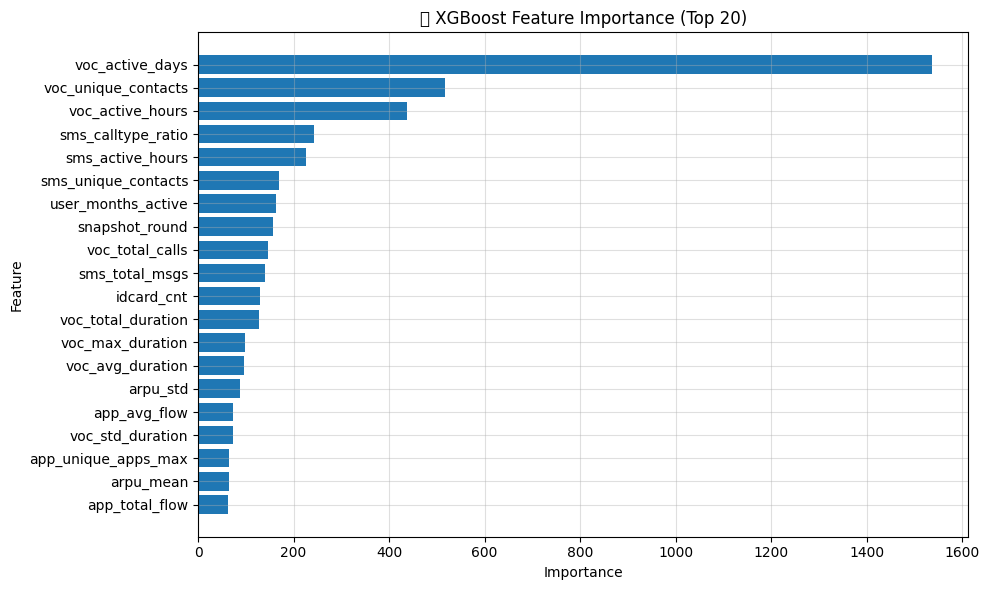

,Feature,Importance
7,voc_active_days,0.188893
2,voc_unique_contacts,0.164015
8,voc_active_hours,0.130353
12,sms_calltype_ratio,0.072825
11,sms_active_hours,0.068712
1,voc_total_calls,0.065106
3,voc_total_duration,0.054928
4,voc_avg_duration,0.042688
24,snapshot_round,0.035825
9,sms_total_msgs,0.031758


/tmp/ipython-input-3543811054.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


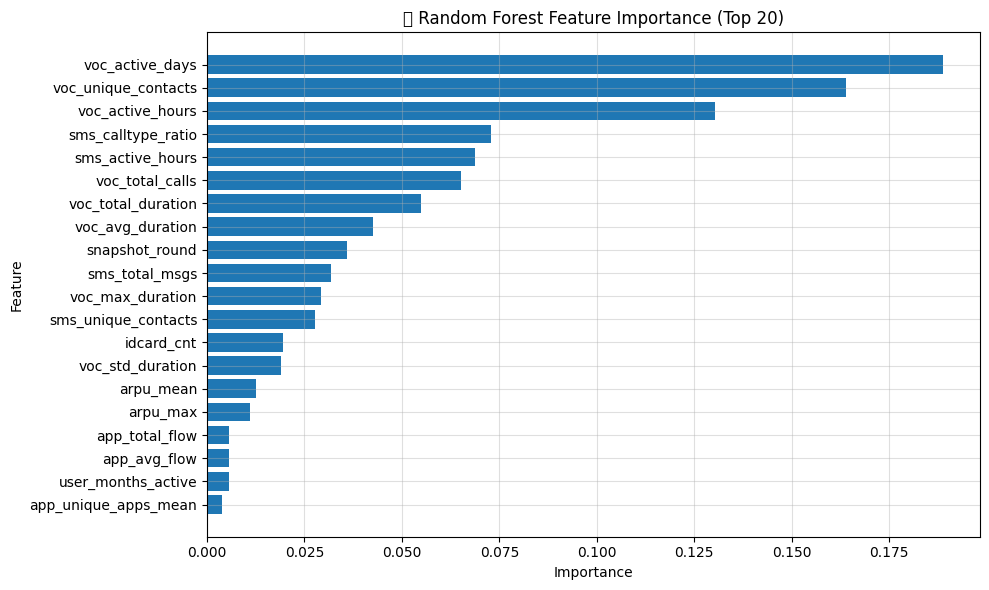

In [18]:
fi_xgb = plot_feature_importance(xgb_model, X_train, "XGBoost")
fi_rf = plot_feature_importance(rf_model, X_train, "Random Forest")


##Timeline based Model

####Generate timeline

###Load

In [19]:
def load_raw_datasets(config):


    if "ML" in config and "Events" in config["ML"]:
        events_cfg = config["ML"]["Events"]
    else:
        events_cfg = config["Events"]

    base = events_cfg["base_path"]
    files = events_cfg["files"]

    # --- Load all datasets ---
    df_voc = pd.read_csv(os.path.join(base, files["voc"]))
    df_sms = pd.read_csv(os.path.join(base, files["sms"]))
    df_app = pd.read_csv(os.path.join(base, files["app"]))
    df_user = pd.read_csv(os.path.join(base, files["user"]))

    # --- Normalize timestamps and add source column ---
    for df, src in [(df_voc, "VOC"), (df_sms, "SMS"), (df_app, "APP"), (df_user, "USER")]:
        df["source"] = src
        ts_col = [c for c in df.columns if "time" in c.lower()][0]
        df.rename(columns={ts_col: "event_time"}, inplace=True)
        df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")

    print("✅ Raw datasets loaded and timestamp-normalized.")
    return df_voc, df_sms, df_app, df_user

df_voc, df_sms, df_app, df_user = load_raw_datasets(config)


✅ Raw datasets loaded and timestamp-normalized.


###Define user sequence

In [20]:

def make_user_sequences(events, feature_cols=None, max_seq_len=100):
    """
    Build per-user sequences for LSTM models.
    Each user's events are sorted by time and padded/truncated to fixed length.

    Parameters
    ----------
    events : pd.DataFrame
        Combined event dataset (all sources).
    feature_cols : list or None
        List of numeric columns to include as features.
        If None, uses all numeric columns except 'label'.
    max_seq_len : int
        Sequence length to pad/truncate to.

    Returns
    -------
    X_seq : np.ndarray
        Array of shape (n_users, max_seq_len, n_features)
    y : np.ndarray
        Array of shape (n_users,)
    users : list
        List of user IDs
    """
    events = events.copy()
    users, X_seq, y = [], [], []

    # 🔹 Encode categorical 'source' column numerically
    le = LabelEncoder()
    events["source_id"] = le.fit_transform(events["source"].astype(str))

    # 🔹 Determine feature columns
    if feature_cols is None:
        feature_cols = events.select_dtypes(include=["number"]).columns.difference(["label"]).tolist()
    if "source_id" not in feature_cols:
        feature_cols.append("source_id")

    print(f"\n📦 Using {len(feature_cols)} features: {feature_cols}")


    # ✅ Build per-user sequences
    for user, df_u in events.groupby("phone_no_m"):
        df_u = df_u.sort_values("event_time")

        feats = df_u[feature_cols].to_numpy(dtype=float)

        # Pad or truncate
        if len(feats) < max_seq_len:
            feats = np.pad(feats, ((max_seq_len - len(feats), 0), (0, 0)))
        else:
            feats = feats[-max_seq_len:]

        # User label = any fraud event → fraud
        label = int(df_u["label"].max())

        X_seq.append(feats)
        y.append(label)
        users.append(user)

    print(f"\n✅ Created sequences for {len(users)} users")
    print(f"   Fraud users: {sum(y)} ({np.mean(y)*100:.2f}%)")
    print(f"   Normal users: {len(y) - sum(y)} ({(1 - np.mean(y))*100:.2f}%)")

    X_seq = np.array(X_seq)
    y = np.array(y)

    print(f"\n📐 Final tensor shape: X={X_seq.shape}, y={y.shape}")
    return X_seq, y, users


###Build timeline (events)

In [21]:
def merge_and_prepare_events(df_voc, df_sms, df_app, df_user):

    # --- 1️⃣ Normalize USER dataset ---
    if 'label' not in df_user.columns:
        raise KeyError("❌ 'label' column not found in user dataset")

    # Ensure numeric consistency
    df_user['label'] = df_user['label'].fillna(0).astype(int)
    df_user['idcard_cnt'] = df_user['idcard_cnt'].fillna(0).astype(float)
    df_user['arpu_value'] = df_user['arpu_value'].fillna(0).astype(float)

    # --- 2️⃣ Extract static info for merging (label + sim count only) ---
    static_user_info = df_user.groupby("phone_no_m", as_index=False)[["label", "idcard_cnt"]].max()

    # --- 3️⃣ Merge static info into other event tables ---
    df_voc = df_voc.merge(static_user_info, on="phone_no_m", how="left")
    df_sms = df_sms.merge(static_user_info, on="phone_no_m", how="left")
    df_app = df_app.merge(static_user_info, on="phone_no_m", how="left")


    # --- 4️⃣ Combine all transactional event sources ---
    # include df_user itself since arpu_value is event-like
    events = pd.concat([df_voc, df_sms, df_app, df_user], ignore_index=True)
    # ✅ Keep only transactional events (VOC + SMS)
    #Drop app and user fee
    #events = pd.concat([df_voc, df_sms], ignore_index=True)

    # --- 5️⃣ Fill and order ---
    events["label"] = events["label"].fillna(0).astype(int)
    events["event_time"] = pd.to_datetime(events["event_time"], errors="coerce")
    events = events.sort_values(["phone_no_m", "event_time"]).reset_index(drop=True)

    # --- 6️⃣ Summary ---
    print("\n🔎 Feature Summary per Source:")
    for src, df in [("VOC", df_voc), ("SMS", df_sms), ("APP", df_app), ("USER", df_user)]:
        print(f"\n📂 Source: {src}")
        print(f"   Events: {len(df):,}")
        print(f"   Users : {df['phone_no_m'].nunique():,}")
        print(f"   Columns ({len(df.columns)}): {', '.join(df.columns)}")

    print("\n📊 Combined Dataset Summary:")
    print(f"   Total events: {len(events):,}")
    print(f"   Unique users: {events['phone_no_m'].nunique():,}")
    print(f"   Fraud ratio: {events['label'].mean()*100:.2f}%")

    return events

events = merge_and_prepare_events(df_voc, df_sms, df_app, df_user)



🔎 Feature Summary per Source:

📂 Source: VOC
   Events: 5,015,430
   Users : 6,025
   Columns (11): phone_no_m, opposite_no_m, calltype_id, event_time, call_dur, city_name, county_name, imei_m, source, label, idcard_cnt

📂 Source: SMS
   Events: 6,848,509
   Users : 6,103
   Columns (7): phone_no_m, opposite_no_m, calltype_id, event_time, source, label, idcard_cnt

📂 Source: APP
   Events: 3,283,602
   Users : 6,106
   Columns (10): phone_no_m, event_time, source, busi_name, flow, month_id, flow_norm, month_str, label, idcard_cnt

📂 Source: USER
   Events: 39,454
   Users : 5,929
   Columns (10): phone_no_m, event_time, source, month_id, arpu_value, city_name, county_name, idcard_cnt, label, month_col

📊 Combined Dataset Summary:
   Total events: 15,186,995
   Unique users: 6,106
   Fraud ratio: 23.90%


###Split

In [22]:


# ======================================
# 0️⃣ Clean Numeric Columns
# ======================================
events = events.copy()
numeric_cols = events.select_dtypes(include=["number"]).columns.difference(["label"])

# Replace NaN with 0 for numeric fields (avoids scaling issues)
events[numeric_cols] = events[numeric_cols].fillna(0)

print(f"\n📊 Numeric columns to scale ({len(numeric_cols)}): {numeric_cols.tolist()}")

# ======================================
# 1️⃣ Scale Numeric Features
# ======================================
scaler_seq = StandardScaler()
events[numeric_cols] = scaler_seq.fit_transform(events[numeric_cols])
print(f"📏 Scaled {len(numeric_cols)} numeric columns for event-level modeling.")

# ======================================
# 2️⃣ Create Train/Test User Split (if not exists)
# ======================================
split_dir = "splits"
train_split_file = f"{split_dir}/train_users.csv"
test_split_file = f"{split_dir}/test_users.csv"

os.makedirs(split_dir, exist_ok=True)

if os.path.exists(train_split_file) and os.path.exists(test_split_file):
    print("📂 Using existing user split from file...")
    train_users = set(pd.read_csv(train_split_file)["phone_no_m"])
    test_users  = set(pd.read_csv(test_split_file)["phone_no_m"])
else:
    print("🆕 Creating new unified user split (for LSTM)...")

    # One label per user
    user_labels = events.groupby("phone_no_m")["label"].max()
    fraud_users = user_labels[user_labels == 1].index
    normal_users = user_labels[user_labels == 0].index

    fraud_train, fraud_test = train_test_split(fraud_users, test_size=0.2, random_state=42)
    normal_train, normal_test = train_test_split(normal_users, test_size=0.2, random_state=42)

    train_users = set(fraud_train) | set(normal_train)
    test_users  = set(fraud_test)  | set(normal_test)

    pd.DataFrame({"phone_no_m": sorted(train_users)}).to_csv(train_split_file, index=False)
    pd.DataFrame({"phone_no_m": sorted(test_users)}).to_csv(test_split_file, index=False)
    print(f"✅ Saved user split to '{split_dir}/'")

print(f"✅ Train users: {len(train_users)} | Test users: {len(test_users)}")

# ======================================
# 3️⃣ Apply Split to Events
# ======================================
train_events = events[events["phone_no_m"].isin(train_users)]
test_events  = events[events["phone_no_m"].isin(test_users)]

# Sanity checks
assert len(set(train_events["phone_no_m"]) & set(test_events["phone_no_m"])) == 0, "❌ User leakage detected!"
assert train_events["label"].nunique() == 2, "❌ Training set must contain both classes"
assert test_events["label"].nunique() == 2, "❌ Test set must contain both classes"

# ======================================
# 4️⃣ Create Sequences (using multiple features)
# ======================================
numeric_features = [c for c in numeric_cols if c not in ["label"]]  # exclude label
max_seq_len=100
print(f"\n📦 Features used for sequences: {numeric_features}")
X_train, y_train, users_train = make_user_sequences(train_events, feature_cols=numeric_features, max_seq_len=max_seq_len)
X_test, y_test, users_test = make_user_sequences(test_events, feature_cols=numeric_features, max_seq_len=max_seq_len)

print("\n✅ Sequence Summary (per-user sequences):")
print(f"   X_train: {X_train.shape} | Fraud ratio: {np.mean(y_train)*100:.2f}%")
print(f"   X_test : {X_test.shape} | Fraud ratio: {np.mean(y_test)*100:.2f}%")

# ======================================
# 5️⃣ Consistency Check
# ======================================
rf_train = set(pd.read_csv(train_split_file)["phone_no_m"])
rf_test  = set(pd.read_csv(test_split_file)["phone_no_m"])
assert rf_train == train_users, "❌ Train user mismatch between LSTM and RF/XGB!"
assert rf_test  == test_users,  "❌ Test user mismatch between LSTM and RF/XGB!"
print("\n🔒 Consistency Check: ✅ Same users used for all models (LSTM, RF, XGBoost).")



📊 Numeric columns to scale (6): ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt']
📏 Scaled 6 numeric columns for event-level modeling.
📂 Using existing user split from file...
✅ Train users: 4742 | Test users: 1187

📦 Features used for sequences: ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt']

📦 Using 7 features: ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt', 'source_id']

✅ Created sequences for 4742 users
   Fraud users: 1430 (30.16%)
   Normal users: 3312 (69.84%)

📐 Final tensor shape: X=(4742, 100, 7), y=(4742,)

📦 Using 7 features: ['arpu_value', 'call_dur', 'calltype_id', 'flow', 'flow_norm', 'idcard_cnt', 'source_id']

✅ Created sequences for 1187 users
   Fraud users: 358 (30.16%)
   Normal users: 829 (69.84%)

📐 Final tensor shape: X=(1187, 100, 7), y=(1187,)

✅ Sequence Summary (per-user sequences):
   X_train: (4742, 100, 7) | Fraud ratio: 30.16%
   X_test : (1187, 100, 7) | Fraud ratio:

###Cor

📊 Correlation Matrix — Raw Event Features (LSTM)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


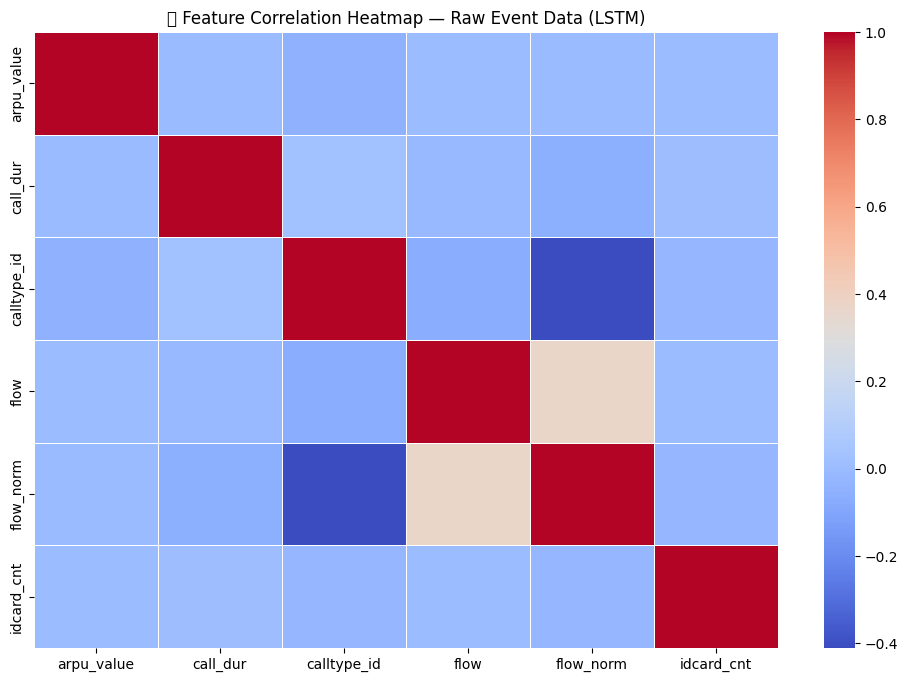

,Feature1,Feature2,Correlation


In [23]:
# --- LSTM correlation ---
print("📊 Correlation Matrix — Raw Event Features (LSTM)")

corr_lstm = pd.DataFrame(events[numeric_cols]).corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_lstm, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("📊 Feature Correlation Heatmap — Raw Event Data (LSTM)")
plt.show()

# Optional: Highly correlated pairs
threshold = 0.85
corr_pairs_lstm = (
    corr_lstm.where(np.triu(np.ones(corr_lstm.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs_lstm.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_lstm = corr_pairs_lstm[corr_pairs_lstm["Correlation"].abs() > threshold]
display(high_corr_lstm)


###F1

In [24]:

def f1_metric(y_true, y_pred):
    # Convert both tensors to float32 before math operations
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')

    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


###Model

In [25]:

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print(class_weights)

# ======================================
# 4️⃣ Build and train LSTM model
# ======================================

lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_seq_len, X_train.shape[2])),
    LSTM(64, return_sequences=False, use_cudnn=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['AUC', 'Recall',f1_metric]
)

print("🚀 Training LSTM...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=64,
    class_weight=class_weights

)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


{0: np.float64(0.7158816425120773), 1: np.float64(1.658041958041958)}
🚀 Training LSTM...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - AUC: 0.8199 - Recall: 0.8167 - f1_metric: 0.3629 - loss: 0.5200 - val_AUC: 0.9101 - val_Recall: 0.7793 - val_f1_metric: 0.2847 - val_loss: 0.3017
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9027 - Recall: 0.7721 - f1_metric: 0.2925 - loss: 0.3513 - val_AUC: 0.9160 - val_Recall: 0.7737 - val_f1_metric: 0.2797 - val_loss: 0.2988
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.9096 - Recall: 0.7752 - f1_metric: 0.2867 - loss: 0.3349 - val_AUC: 0.9192 - val_Recall: 0.7793 - val_f1_metric: 0.2787 - val_loss: 0.2930
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.9134 - Recall: 0.7825 - f1_metric: 0.2843 - loss: 0.3307 - val_AUC: 0.9204 - val_Recall: 0.8073 - val_f1_metric: 0.2922 - val_loss: 0.3280
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.9135 - Recall: 0.7930 - f1_metric: 0.2961 - loss: 0.34

###Test

In [26]:

# Predict probabilities and labels
y_pred_prob = lstm_model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


###Report

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Classification Report — LSTM
              precision    recall  f1-score   support

           0     0.9208    0.9397    0.9301       829
           1     0.8534    0.8128    0.8326       358

    accuracy                         0.9014      1187
   macro avg     0.8871    0.8763    0.8814      1187
weighted avg     0.9005    0.9014    0.9007      1187

AUC: 0.9211 | Recall: 0.8128


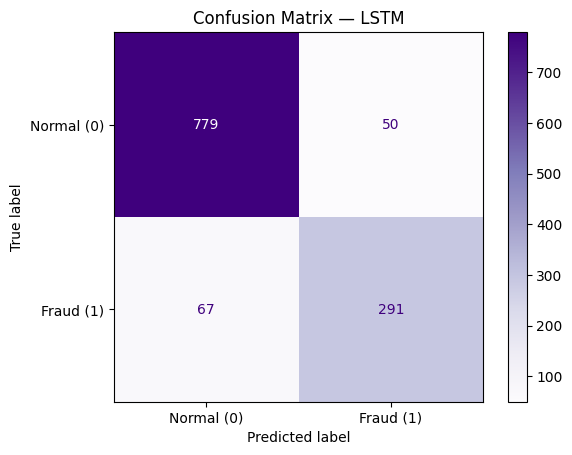

In [27]:

def evaluate_lstm_global(model, X_test, y_test, model_name="LSTM"):
    """
    Evaluate trained LSTM on test sequences.
    Displays classification report and confusion matrix.
    """
    # Predict probabilities and labels
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f"\n📊 Classification Report — {model_name}")
    print(report)
    print(f"AUC: {auc:.4f} | Recall: {recall:.4f}")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Fraud (1)"])
    disp.plot(cmap="Purples")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.grid(False)
    plt.show()

    return {
        "model": model_name,
        "AUC": auc,
        "Recall": recall,
        "Precision": classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        "F1": classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    }
lstm_results = evaluate_lstm_global(lstm_model, X_test, y_test, "LSTM")
lstm_results["Model"] = lstm_results.pop("model")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


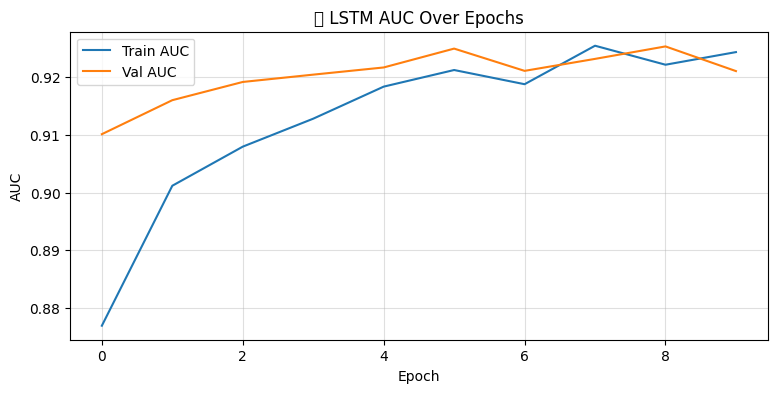

/tmp/ipython-input-2765719348.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


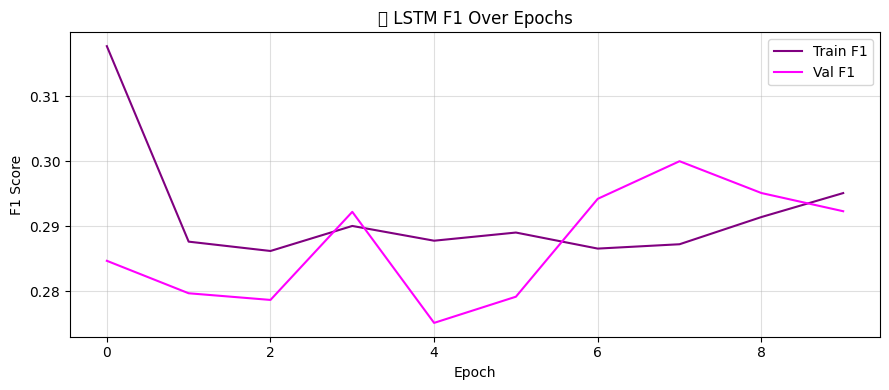

,Model,AUC,Recall,Precision,F1
0,XGBoost,0.850587,0.728244,0.654352,0.689323
1,Random Forest,0.848567,0.578024,0.790544,0.667783
2,LSTM,0.921141,0.812849,0.853372,0.832618


In [28]:


plt.figure(figsize=(9,4))
plt.plot(lstm_history.history['AUC'], label='Train AUC')
plt.plot(lstm_history.history['val_AUC'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('📈 LSTM AUC Over Epochs')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()
# Append LSTM to summary comparison
# Completely reset (delete all data)
plt.figure(figsize=(9,4))
plt.plot(lstm_history.history['f1_metric'], label='Train F1', color='purple')
plt.plot(lstm_history.history['val_f1_metric'], label='Val F1', color='magenta')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('📈 LSTM F1 Over Epochs')
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


summary = pd.concat([summary, pd.DataFrame([lstm_results])], ignore_index=True)
display(summary)


#Advance ML Model

###Time Encode

In [29]:
# ==========================================================
# Flexible Time Encoder (supports multiple time representations)
class TimeEncoder(nn.Module):
    def __init__(self, mode='time2vec', k=7, d_model=8):
        super().__init__()
        self.mode = mode
        self.k = k
        self.d_model = d_model

        if mode == 'time2vec':
            self.wb = nn.Linear(1, 1)
            self.w = nn.Linear(1, k)
        elif mode == 'fourier':
            self.freqs = nn.Parameter(torch.linspace(0.1, 1.0, k))
        elif mode == 'embedding':
            self.hour_emb = nn.Embedding(24, d_model)
        elif mode == 'delta':
            self.proj = nn.Linear(1, d_model)

    def forward(self, t):
        # Ensure input shape is [B, T]
        if t.ndim == 3 and t.shape[-1] == 1:
            t = t.squeeze(-1)
        elif t.ndim == 1:
            t = t.unsqueeze(0)

        if self.mode == 'time2vec':
            t = t.unsqueeze(-1)  # [B, T, 1]
            wb = self.wb(t)
            w = torch.sin(self.w(t))
            out = torch.cat([wb, w], dim=-1)  # [B, T, k+1]

        elif self.mode == 'fourier':
            freqs = self.freqs[None, None, :] * t[..., None]
            out = torch.cat([torch.sin(2 * np.pi * freqs),
                             torch.cos(2 * np.pi * freqs)], dim=-1)  # [B, T, 2k]

        elif self.mode == 'embedding':
            hour = (t.long() % 24)
            out = self.hour_emb(hour)  # [B, T, d_model]

        elif self.mode == 'delta':
            t_log = torch.log1p(t).unsqueeze(-1)
            out = self.proj(t_log)  # [B, T, d_model]

        return out


time_mode='time2vec'

##Transformer

###Build sequence

In [30]:
# ==============================================================
# NEW: Transformer helpers (no changes to existing LSTM path)
# ==============================================================


def build_tf_sequences(events, feature_cols=None, max_seq_len=100):
    """
    Build Transformer-ready sequences with:
      - X_seq:      [n_users, T, F]   numeric features
      - DT_seq:     [n_users, T, 1]   delta-time (hours) feature
      - PAD_mask:   [n_users, T]      True where PAD
      - y_user:     [n_users]         user labels
      - users:      list              phone_no_m
    NOTE: This is separate from make_user_sequences(); it does not replace it.
    """
    events = events.copy()
    users, X_seq, DT_seq, PAD_mask, y_user = [], [], [], [], []

    # Ensure numeric source_id exists (you already add it elsewhere)
    if "source_id" not in events.columns:

        le = LabelEncoder()
        events["source_id"] = le.fit_transform(events["source"].astype(str))

    # Default: all numeric except label
    if feature_cols is None:
        feature_cols = events.select_dtypes(include=["number"]).columns.difference(["label"]).tolist()
    if "source_id" not in feature_cols:
        feature_cols.append("source_id")

    for user, df_u in events.groupby("phone_no_m"):
        df_u = df_u.sort_values("event_time")

        # delta-time in hours between events (0 for first)
        dt_hours = df_u["event_time"].diff().dt.total_seconds().fillna(0) / 3600.0
        dt_hours = dt_hours.to_numpy(dtype=float).reshape(-1, 1)

        feats = df_u[feature_cols].to_numpy(dtype=float)
        L = len(feats)

        # Build padding mask: True where PAD (we left-pad to keep most recent)
        if L < max_seq_len:
            pad_len = max_seq_len - L
            feats   = np.pad(feats,   ((pad_len, 0), (0, 0)))
            dt_hours= np.pad(dt_hours,((pad_len, 0), (0, 0)))
            pad_mask = np.zeros((max_seq_len,), dtype=bool)
            pad_mask[:pad_len] = True
        else:
            feats    = feats[-max_seq_len:]
            dt_hours = dt_hours[-max_seq_len:]
            pad_mask = np.zeros((max_seq_len,), dtype=bool)

        label = int(df_u["label"].max())

        X_seq.append(feats)
        DT_seq.append(dt_hours)
        PAD_mask.append(pad_mask)
        y_user.append(label)
        users.append(user)

    X_seq   = np.stack(X_seq)
    DT_seq  = np.stack(DT_seq)
    PAD_mask= np.stack(PAD_mask)
    y_user  = np.array(y_user, dtype=int)
    return X_seq, DT_seq, PAD_mask, y_user, users



###Transformer model

In [31]:

# ----------------- PyTorch Transformer model -----------------

class Time2Vec(nn.Module):
    def __init__(self, k=7):  # k periodic components
        super().__init__()
        self.w0 = nn.Parameter(torch.randn(1))
        self.b0 = nn.Parameter(torch.randn(1))
        self.w  = nn.Parameter(torch.randn(k))
        self.b  = nn.Parameter(torch.randn(k))
        self.k  = k

    def forward(self, t):  # t: [B, T, 1]
        v0 = self.w0 * t + self.b0                # [B, T, 1]
        vp = torch.sin(self.w * t + self.b)       # [B, T, k] (broadcast)
        return torch.cat([v0, vp], dim=-1)        # [B, T, 1+k]


class TransformerFraud(nn.Module):
    def __init__(self, input_dim, d_model=128, n_heads=4, n_layers=2, time_k=7):
        super().__init__()
        self.time2vec = TimeEncoder(mode=time_mode, k=time_k)
        self.proj = nn.Linear(input_dim + (1 + time_k), d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.cls = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64, 1)
        )

    def forward(self, x, dt_hours, pad_mask=None):  # x:[B,T,F], dt:[B,T,1], pad_mask:[B,T] (True=PAD)
        x = torch.cat([x, self.time2vec(dt_hours)], dim=-1)  # augment with time code
        h = self.proj(x)
        h = self.encoder(h, src_key_padding_mask=pad_mask)   # mask: True entries ignored
        # mask-aware mean pool
        if pad_mask is not None:
            keep = (~pad_mask).unsqueeze(-1)                 # [B,T,1]
            denom = keep.sum(dim=1).clamp(min=1)
            h = (h * keep).sum(dim=1) / denom
        else:
            h = h.mean(dim=1)
        logit = self.cls(h).squeeze(-1)
        return torch.sigmoid(logit)


###Create seq

In [32]:
# ==============================================================
# NEW: Transformer training path (keeps LSTM/RF/XGB untouched)
# ==============================================================

print("\n🧪 [Transformer] Building sequences...")
max_seq_len_tf = 100

# Build Transformer-ready sequences (no leakage; uses your existing train/test splits)
Xtr_raw, DTr_raw, Mtr, ytr, users_tr = build_tf_sequences(train_events, max_seq_len=max_seq_len_tf)
Xte_raw, DTe_raw, Mte, yte, users_te = build_tf_sequences(test_events,  max_seq_len=max_seq_len_tf)



🧪 [Transformer] Building sequences...


###Scale, prepare  and select processing

In [33]:
# Scale numeric features (fit only on training)


num_features = Xtr_raw.shape[2]
scaler_tf = StandardScaler().fit(Xtr_raw.reshape(-1, num_features))
Xtr = scaler_tf.transform(Xtr_raw.reshape(-1, num_features)).reshape(Xtr_raw.shape)
Xte = scaler_tf.transform(Xte_raw.reshape(-1, num_features)).reshape(Xte_raw.shape)

# Convert to tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)


Xtr_t = torch.tensor(Xtr, dtype=torch.float32).to(device)
Xte_t = torch.tensor(Xte, dtype=torch.float32).to(device)
DTr_t = torch.tensor(DTr_raw, dtype=torch.float32).to(device)
DTe_t = torch.tensor(DTe_raw, dtype=torch.float32).to(device)
Mtr_t = torch.tensor(Mtr, dtype=torch.bool).to(device)
Mte_t = torch.tensor(Mte, dtype=torch.bool).to(device)
ytr_t = torch.tensor(ytr, dtype=torch.float32).to(device)
yte_t = torch.tensor(yte, dtype=torch.float32).to(device)

# DataLoaders
train_ds = TensorDataset(Xtr_t, DTr_t, Mtr_t, ytr_t)
test_ds  = TensorDataset(Xte_t, DTe_t, Mte_t, yte_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)




device(type='cuda')

###Transformer training

In [34]:

# Instantiate Transformer model
model_tf = TransformerFraud(input_dim=Xtr.shape[2], d_model=128, n_heads=4, n_layers=2, time_k=7).to(device)
opt = torch.optim.Adam(model_tf.parameters(), lr=1e-4)
bce = torch.nn.BCELoss()#Binary Cross-Entropy Loss

# Training loop
epochs = 5
for ep in range(1, epochs + 1):
    model_tf.train()
    loss_sum = 0.0
    for xb, dtb, mb, yb in train_loader:
        pred = model_tf(xb, dtb, pad_mask=mb)
        loss = bce(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum += loss.item() * len(xb)
    print(f"[Transformer][Epoch {ep}] train_loss={loss_sum / len(train_ds):.4f}")

# Evaluation


model_tf.eval()
with torch.no_grad():
    preds = []
    for xb, dtb, mb, yb in test_loader:
        p = model_tf(xb, dtb, pad_mask=mb)
        preds.append(p.detach().cpu().numpy())
    p_te = np.concatenate(preds)

auc  = roc_auc_score(yte, p_te)
ap   = average_precision_score(yte, p_te)
print(f"[Transformer] Test ROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f}")

tf_user_scores = pd.DataFrame({"phone_no_m": users_te, "p_tf": p_te, "y": yte})
print("✅ [Transformer] Inference complete. Sample:")
print(tf_user_scores.head())

[Transformer][Epoch 1] train_loss=0.3447
[Transformer][Epoch 2] train_loss=0.2748
[Transformer][Epoch 3] train_loss=0.2648
[Transformer][Epoch 4] train_loss=0.2629
[Transformer][Epoch 5] train_loss=0.2528
[Transformer] Test ROC-AUC: 0.9267 | PR-AUC: 0.9134
✅ [Transformer] Inference complete. Sample:
                                          phone_no_m      p_tf  y
0  007779e751d2bab37e1460d70c1ae509e0906f551d75f6...  0.033096  0
1  0084a5eb515145e14512381ec28a35a50201319b9e375b...  0.074719  0
2  00a9d555a4aadee583020ecb88b9ae699369beb9bd8608...  0.838752  0
3  00ce4bced665c59f1ca1fb5d33400cbff63697a15e095a...  0.115546  0
4  00faed316c430581f64436305ba8e5be529ff934ef3a9a...  0.032136  0


### Tansformer report

[Transformer] Precision: 0.9414 | Recall: 0.7626 | F1-score: 0.8426


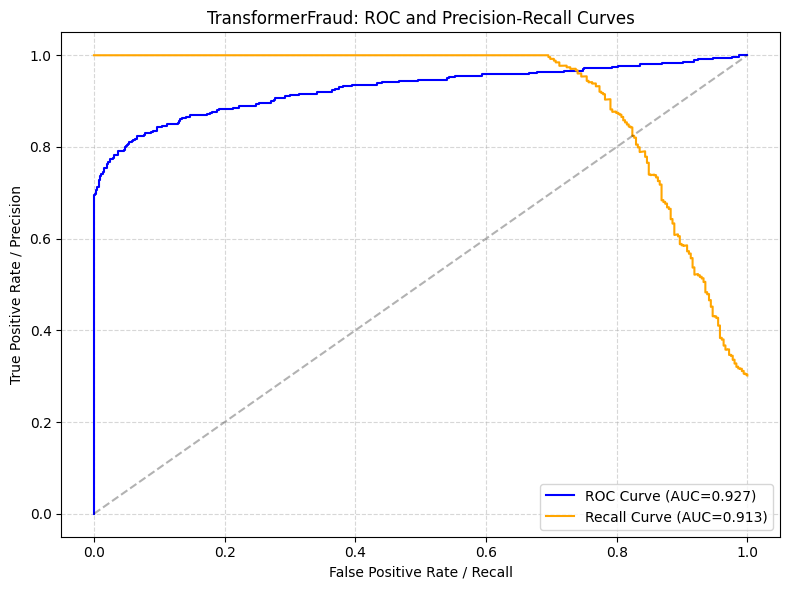

,Model,AUC,Recall,Precision,F1
0,XGBoost,0.850587,0.728244,0.654352,0.689323
1,Random Forest,0.848567,0.578024,0.790544,0.667783
2,LSTM,0.921141,0.812849,0.853372,0.832618
3,TransformerFraud,0.926700,0.762600,0.941400,0.842600


In [35]:
# ==============================================================
# ADDITION: Extended Transformer evaluation metrics + combined plot
# ==============================================================


# Convert probabilities to binary predictions
threshold = 0.5
pred_label = (p_te >= threshold).astype(int)

# Compute additional metrics
precision = precision_score(yte, pred_label)
recall = recall_score(yte, pred_label)
f1 = f1_score(yte, pred_label)

print(f"[Transformer] Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

# Curves
fpr, tpr, _ = roc_curve(yte, p_te)
prec, rec, _ = precision_recall_curve(yte, p_te)

# Combined ROC and PR plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})", color='blue')
plt.plot(rec, prec, label=f"Recall Curve (AUC={ap:.3f})", color='orange')
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate / Recall")
plt.ylabel("True Positive Rate / Precision")
plt.title("TransformerFraud: ROC and Precision-Recall Curves")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ==============================================================
# SYNCED SUMMARY ENTRY — same structure as LSTM, RF, XGB
# ==============================================================

# Drop any old TransformerFraud entry
summary = summary[summary["Model"] != "TransformerFraud"]

# Create results dictionary (consistent with evaluate_lstm_global output)
transformer_results = {
    "Model": "TransformerFraud",
    "AUC": round(auc, 4),
    "Recall": round(recall, 4),
    "Precision": round(precision, 4),
    "F1": round(f1, 4)
}

# Add PR-AUC only if you want to extend (not required for sync)
#transformer_results["PR-AUC"] = round(ap, 4)

# Standardize columns
expected_cols = ["Model", "AUC", "Recall", "Precision", "F1"]
if "summary" not in locals():
    summary = pd.DataFrame(columns=expected_cols)

# Concatenate and reindex
summary = pd.concat([summary, pd.DataFrame([transformer_results])], ignore_index=True)
summary = summary.reindex(columns=expected_cols)

display(summary)



##Mamba

###Mamba Model

In [36]:

class MambaFraud(nn.Module):
    def __init__(self, input_dim, d_model=128, d_state=16, d_conv=4, expand=2, time_k=7):
        super().__init__()
        #self.time2vec = Time2Vec(time_k)
        self.time2vec = TimeEncoder(mode=time_mode, k=time_k)
        self.proj = nn.Linear(input_dim + (1 + time_k), d_model)

        # ✅ Core Mamba sequence model
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )

        self.cls = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()    # Binary classification
        )

    def forward(self, X, D, M):
        # Concatenate time2vec output
        t = self.time2vec(D)
        x = torch.cat([X, t], dim=-1)
        x = self.proj(x)

        # Pass through Mamba
        x = self.mamba(x)

        # Use mean pooling across time dimension
        x = x.mean(dim=1)
        return self.cls(x)


###Mamba Training

In [37]:
# Instantiate Mamba model
model_mamba = MambaFraud(input_dim=Xtr.shape[2], d_model=128, time_k=7).to(device)
opt = torch.optim.Adam(model_mamba.parameters(), lr=1e-4)
bce = torch.nn.BCELoss()  # Binary Cross-Entropy Loss

# Training loop
epochs = 5
for ep in range(1, epochs + 1):
    model_mamba.train()
    loss_sum = 0.0
    for xb, dtb, mb, yb in train_loader:
        pred = model_mamba(xb, dtb, mb)
        if yb.dim() == 1:
          yb = yb.unsqueeze(1)
        loss = bce(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum += loss.item() * len(xb)
    print(f"[Mamba][Epoch {ep}] train_loss={loss_sum / len(train_ds):.4f}")

# Evaluation


model_mamba.eval()
with torch.no_grad():
    preds = []
    for xb, dtb, mb, yb in test_loader:
        p = model_mamba(xb, dtb, mb)
        preds.append(p.detach().cpu().numpy())

p_te = np.concatenate(preds).ravel()  # ✅ ensure 1D

auc  = roc_auc_score(yte, p_te)
ap   = average_precision_score(yte, p_te)
rec  = recall_score(yte, (p_te > 0.5).astype(int))
f1   = f1_score(yte, (p_te > 0.5).astype(int))

print(f"[Mamba] Test ROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

mamba_user_scores = pd.DataFrame({
    "phone_no_m": users_te,
    "p_mamba": p_te,
    "y": yte
})

print("✅ [Mamba] Inference complete. Sample:")
print(mamba_user_scores.head())



[Mamba][Epoch 1] train_loss=1.1465
[Mamba][Epoch 2] train_loss=1.0136
[Mamba][Epoch 3] train_loss=0.8826
[Mamba][Epoch 4] train_loss=0.7561
[Mamba][Epoch 5] train_loss=0.6766
[Mamba] Test ROC-AUC: 0.8850 | PR-AUC: 0.8269 | Recall: 0.6592 | F1: 0.7750
✅ [Mamba] Inference complete. Sample:
                                          phone_no_m   p_mamba  y
0  007779e751d2bab37e1460d70c1ae509e0906f551d75f6...  0.066254  0
1  0084a5eb515145e14512381ec28a35a50201319b9e375b...  0.144722  0
2  00a9d555a4aadee583020ecb88b9ae699369beb9bd8608...  0.386518  0
3  00ce4bced665c59f1ca1fb5d33400cbff63697a15e095a...  0.098675  0
4  00faed316c430581f64436305ba8e5be529ff934ef3a9a...  0.112225  0


###Mamba Report

[Mamba] Precision: 0.9402 | Recall: 0.6592 | F1-score: 0.7750


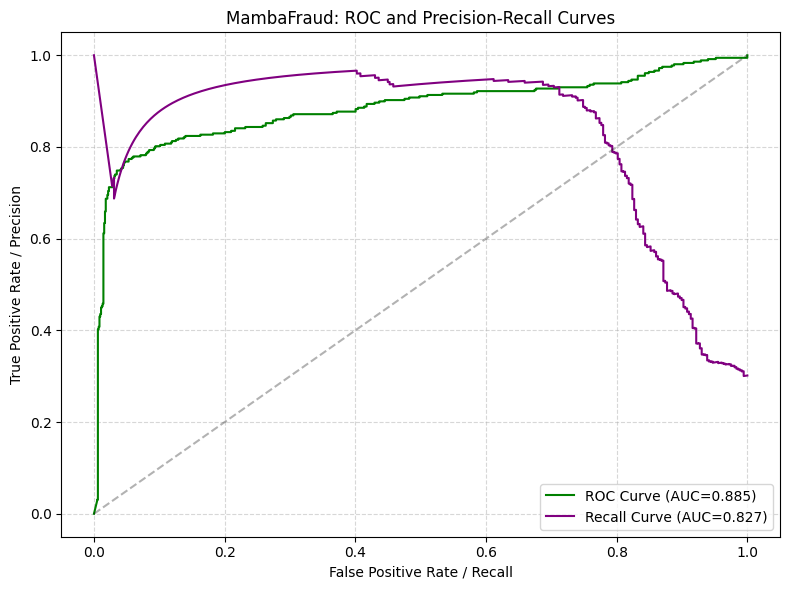

,Model,AUC,Recall,Precision,F1
0,XGBoost,0.850587,0.728244,0.654352,0.689323
1,Random Forest,0.848567,0.578024,0.790544,0.667783
2,LSTM,0.921141,0.812849,0.853372,0.832618
3,TransformerFraud,0.926700,0.762600,0.941400,0.842600
4,MambaFraud,0.885000,0.659200,0.940200,0.775000


In [38]:
# ==============================================================
# ADDITION: Extended Mamba evaluation metrics + combined plot
# ==============================================================

# Convert probabilities to binary predictions
threshold = 0.5
pred_label = (p_te >= threshold).astype(int)

# Compute additional metrics
precision = precision_score(yte, pred_label)
recall = recall_score(yte, pred_label)
f1 = f1_score(yte, pred_label)

print(f"[Mamba] Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

# Curves
fpr, tpr, _ = roc_curve(yte, p_te)
prec, rec, _ = precision_recall_curve(yte, p_te)

# Combined ROC and PR plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})", color='green')
plt.plot(rec, prec, label=f"Recall Curve (AUC={ap:.3f})", color='purple')
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate / Recall")
plt.ylabel("True Positive Rate / Precision")
plt.title("MambaFraud: ROC and Precision-Recall Curves")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ==============================================================
# SYNCED SUMMARY ENTRY — same structure as LSTM, RF, XGB
# ==============================================================

# Drop any old Mamba entry
summary = summary[summary["Model"] != "MambaFraud"]

# Create results dictionary
mamba_results = {
    "Model": "MambaFraud",
    "AUC": round(auc, 4),
    "Recall": round(recall, 4),
    "Precision": round(precision, 4),
    "F1": round(f1, 4)
}

# Optional: include PR-AUC if you like
#mamba_results["PR-AUC"] = round(ap, 4)

# Standardize columns
expected_cols = ["Model", "AUC", "Recall", "Precision", "F1"]
if "summary" not in locals():
    summary = pd.DataFrame(columns=expected_cols)

# Concatenate and reindex
summary = pd.concat([summary, pd.DataFrame([mamba_results])], ignore_index=True)
summary = summary.reindex(columns=expected_cols)

display(summary)


#Time

##Informer

###Model

In [39]:
# ======================================
# 1) InformerFraud (lite) - Model
# ======================================


class _InfEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, d_ff=256, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model), nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, key_padding_mask=None):
        # Self-attention
        attn_out, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask, need_weights=False)
        x = self.norm1(x + attn_out)
        # Feed-forward
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class _DistilBlock(nn.Module):
    """Downsample sequence length by 2 (Informer 'distilling')."""
    def __init__(self, d_model):
        super().__init__()
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=3, stride=2, padding=1)
        self.act = nn.GELU()
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x: [B,T,C] -> [B,C,T] -> downsample -> [B,T',C]
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.transpose(1, 2)
        return self.norm(x)

class InformerFraud(nn.Module):
    def __init__(self, input_dim, d_model=128, n_heads=4, e_layers=2, d_ff=256, dropout=0.1, time_k=7, use_distill=True):
        super().__init__()
        #self.time2vec = Time2Vec(time_k)
        self.time2vec = TimeEncoder(mode=time_mode, k=time_k)
        self.proj = nn.Linear(input_dim + (1 + time_k), d_model)

        self.encoders = nn.ModuleList([_InfEncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(e_layers)])
        self.use_distill = use_distill and e_layers > 1
        if self.use_distill:
            self.distillers = nn.ModuleList([_DistilBlock(d_model) for _ in range(e_layers - 1)])

        self.head = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())

    def forward(self, x, dt_hours, pad_mask=None):
        # concat raw Δt encoding
        t2v = self.time2vec(dt_hours)
        h = torch.cat([x, t2v], dim=-1)
        h = self.proj(h)

        # stacked encoder with optional distilling between layers
        for i, enc in enumerate(self.encoders):
            h = enc(h, key_padding_mask=pad_mask)
            if self.use_distill and i < len(self.encoders) - 1:
                # when we downsample time, also downsample the pad_mask
                h = self.distillers[i](h)
                if pad_mask is not None:
                    # take every 2nd timestep (OR over pairs to keep "padded" true)
                    pad_mask = pad_mask[:, ::2] | pad_mask[:, 1::2]

        # mask-aware mean pooling
        if pad_mask is not None:
            keep = (~pad_mask).unsqueeze(-1)
            denom = keep.sum(dim=1).clamp(min=1)
            h = (h * keep).sum(dim=1) / denom
        else:
            h = h.mean(dim=1)

        return self.head(h)


###training

In [40]:
# ======================================
# 2) InformerFraud - Train
# ======================================
model_informer = InformerFraud(input_dim=Xtr.shape[2], d_model=128, n_heads=4, e_layers=2, d_ff=256, time_k=7).to(device)
opt = torch.optim.Adam(model_informer.parameters(), lr=1e-4)
bce = torch.nn.BCELoss()

epochs = 5
for ep in range(1, epochs + 1):
    model_informer.train()
    loss_sum = 0.0
    for xb, dtb, mb, yb in train_loader:
        pred = model_informer(xb, dtb, mb)
        if yb.dim() == 1: yb = yb.unsqueeze(1)
        loss = bce(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item() * len(xb)
    print(f"[Informer][Epoch {ep}] train_loss={loss_sum / len(train_ds):.4f}")


[Informer][Epoch 1] train_loss=0.3466
[Informer][Epoch 2] train_loss=0.2790
[Informer][Epoch 3] train_loss=0.2734
[Informer][Epoch 4] train_loss=0.2646
[Informer][Epoch 5] train_loss=0.2566


###evaluation

[Informer] ROC-AUC=0.9208 | PR-AUC=0.9081 | Precision=0.9320 | Recall=0.7654 | F1=0.8405


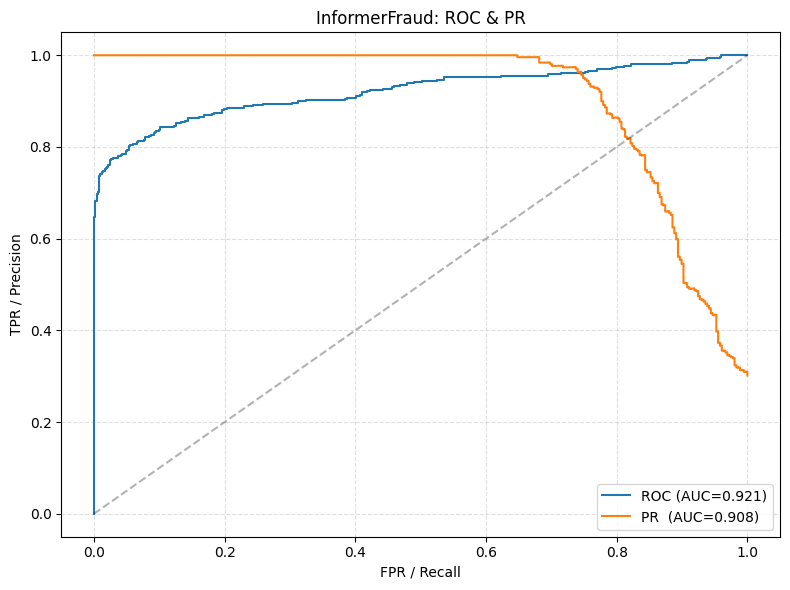

,Model,AUC,Recall,Precision,F1,PR-AUC
0,XGBoost,0.850587,0.728244,0.654352,0.689323,NaN
1,Random Forest,0.848567,0.578024,0.790544,0.667783,NaN
2,LSTM,0.921141,0.812849,0.853372,0.832618,NaN
3,TransformerFraud,0.926700,0.762600,0.941400,0.842600,NaN
4,MambaFraud,0.885000,0.659200,0.940200,0.775000,NaN
5,InformerFraud,0.920800,0.765400,0.932000,0.840500,0.9081


In [41]:
# ======================================
# 3) InformerFraud - Eval + Plot + Summary
# ======================================


model_informer.eval()
with torch.no_grad():
    preds = []
    for xb, dtb, mb, yb in test_loader:
        p = model_informer(xb, dtb, mb)
        preds.append(p.detach().cpu().numpy())
p_te = np.concatenate(preds).ravel()

auc  = roc_auc_score(yte, p_te)
ap   = average_precision_score(yte, p_te)
pred = (p_te >= 0.5).astype(int)
prec = precision_score(yte, pred, zero_division=0)
rec  = recall_score(yte, pred, zero_division=0)
f1   = f1_score(yte, pred, zero_division=0)

print(f"[Informer] ROC-AUC={auc:.4f} | PR-AUC={ap:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

# Combined ROC/PR
fpr, tpr, _ = roc_curve(yte, p_te)
prp, prr, _ = precision_recall_curve(yte, p_te)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot(prr, prp, label=f"PR  (AUC={ap:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.3)
plt.xlabel("FPR / Recall"); plt.ylabel("TPR / Precision")
plt.title("InformerFraud: ROC & PR")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
plt.show()

# Summary row (de-dup + append)
row = {"Model":"InformerFraud","AUC":round(auc,4),"PR-AUC":round(ap,4),"Recall":round(rec,4),"Precision":round(prec,4),"F1":round(f1,4)}
if "summary" not in locals():
    summary = pd.DataFrame(columns=["Model","AUC","PR-AUC","Recall","Precision","F1"])
summary = summary[summary["Model"] != "InformerFraud"]
summary = pd.concat([summary, pd.DataFrame([row])], ignore_index=True)
display(summary)


##TimesNet

###Model

In [42]:
# ======================================

class _TimesBlock(nn.Module):
    """Multi-scale temporal conv block (1D) approximating TimesNet behavior."""
    def __init__(self, d_model=128, ks=(3,5,7,11), dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(d_model, d_model, kernel_size=k, padding=k//2),
                nn.GELU(),
                nn.Conv1d(d_model, d_model, kernel_size=1),
            ) for k in ks
        ])
        self.proj = nn.Conv1d(d_model*len(ks), d_model, kernel_size=1)
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x: [B,T,C] -> [B,C,T]
        x_in = x.transpose(1,2)
        outs = [branch(x_in) for branch in self.branches]  # each [B,C,T]
        h = torch.cat(outs, dim=1)                         # [B,C*B,T]
        h = self.proj(h)                                   # [B,C,T]
        h = h.transpose(1,2)                               # [B,T,C]
        h = self.drop(h)
        return self.norm(h + x)                            # residual

class TimesNetFraud(nn.Module):
    def __init__(self, input_dim, d_model=128, depth=3, time_k=7, dropout=0.1):
        super().__init__()
        #self.time2vec = Time2Vec(time_k)
        self.time2vec = TimeEncoder(mode=time_mode, k=time_k)
        self.proj = nn.Linear(input_dim + (1 + time_k), d_model)
        self.blocks = nn.ModuleList([_TimesBlock(d_model=d_model, dropout=dropout) for _ in range(depth)])
        self.head = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())

    def forward(self, x, dt_hours, pad_mask=None):
        t2v = self.time2vec(dt_hours)
        h = torch.cat([x, t2v], dim=-1)
        h = self.proj(h)
        for blk in self.blocks:
            h = blk(h)

        # mask-aware mean pool
        if pad_mask is not None:
            keep = (~pad_mask).unsqueeze(-1)
            denom = keep.sum(dim=1).clamp(min=1)
            h = (h * keep).sum(dim=1) / denom
        else:
            h = h.mean(dim=1)

        return self.head(h)


###training

In [43]:
# ======================================
# 5) TimesNetFraud - Train
# ======================================
model_timesnet = TimesNetFraud(input_dim=Xtr.shape[2], d_model=128, depth=3, time_k=7).to(device)
opt = torch.optim.Adam(model_timesnet.parameters(), lr=1e-4)
bce = torch.nn.BCELoss()

epochs = 5
for ep in range(1, epochs + 1):
    model_timesnet.train()
    loss_sum = 0.0
    for xb, dtb, mb, yb in train_loader:
        pred = model_timesnet(xb, dtb, mb)
        if yb.dim() == 1: yb = yb.unsqueeze(1)
        loss = bce(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item() * len(xb)
    print(f"[TimesNet][Epoch {ep}] train_loss={loss_sum / len(train_ds):.4f}")


[TimesNet][Epoch 1] train_loss=0.4226
[TimesNet][Epoch 2] train_loss=0.3139
[TimesNet][Epoch 3] train_loss=0.3056
[TimesNet][Epoch 4] train_loss=0.2957
[TimesNet][Epoch 5] train_loss=0.2892


###evaluation

[TimesNet] ROC-AUC=0.9041 | PR-AUC=0.8845 | Precision=0.9375 | Recall=0.7123 | F1=0.8095


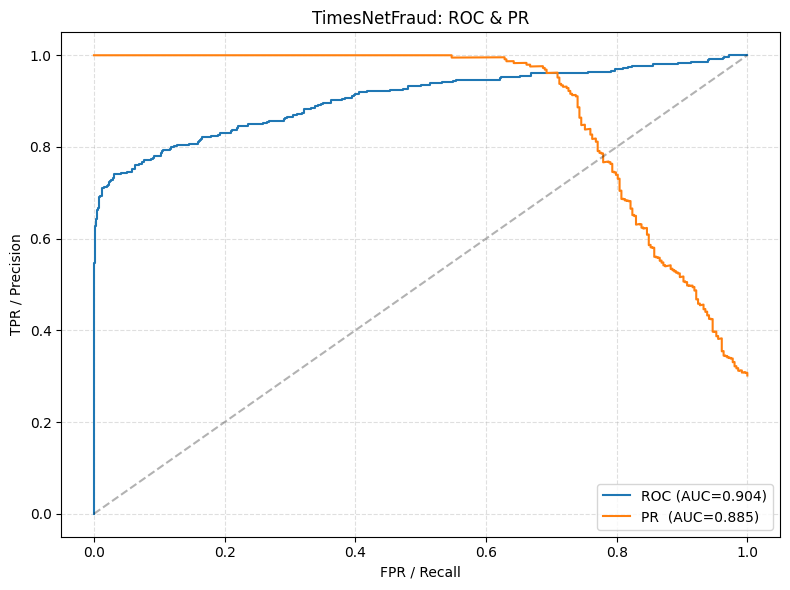

,Model,AUC,Recall,Precision,F1,PR-AUC
0,XGBoost,0.850587,0.728244,0.654352,0.689323,NaN
1,Random Forest,0.848567,0.578024,0.790544,0.667783,NaN
2,LSTM,0.921141,0.812849,0.853372,0.832618,NaN
3,TransformerFraud,0.926700,0.762600,0.941400,0.842600,NaN
4,MambaFraud,0.885000,0.659200,0.940200,0.775000,NaN
5,InformerFraud,0.920800,0.765400,0.932000,0.840500,0.9081
6,TimesNetFraud,0.904100,0.712300,0.937500,0.809500,0.8845


In [44]:
# ======================================
# 6) TimesNetFraud - Eval + Plot + Summary
# ======================================
model_timesnet.eval()
with torch.no_grad():
    preds = []
    for xb, dtb, mb, yb in test_loader:
        p = model_timesnet(xb, dtb, mb)
        preds.append(p.detach().cpu().numpy())
p_te = np.concatenate(preds).ravel()

auc  = roc_auc_score(yte, p_te)
ap   = average_precision_score(yte, p_te)
pred = (p_te >= 0.5).astype(int)
prec = precision_score(yte, pred, zero_division=0)
rec  = recall_score(yte, pred, zero_division=0)
f1   = f1_score(yte, pred, zero_division=0)

print(f"[TimesNet] ROC-AUC={auc:.4f} | PR-AUC={ap:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f}")

# Combined ROC/PR
fpr, tpr, _ = roc_curve(yte, p_te)
prp, prr, _ = precision_recall_curve(yte, p_te)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot(prr, prp, label=f"PR  (AUC={ap:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.3)
plt.xlabel("FPR / Recall"); plt.ylabel("TPR / Precision")
plt.title("TimesNetFraud: ROC & PR")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout()
plt.show()

# Summary row (de-dup + append)
row = {"Model":"TimesNetFraud","AUC":round(auc,4),"PR-AUC":round(ap,4),"Recall":round(rec,4),"Precision":round(prec,4),"F1":round(f1,4)}
if "summary" not in locals():
    summary = pd.DataFrame(columns=["Model","AUC","PR-AUC","Recall","Precision","F1"])
summary = summary[summary["Model"] != "TimesNetFraud"]
summary = pd.concat([summary, pd.DataFrame([row])], ignore_index=True)
display(summary)


#Pretrained

#freeze

In [ ]:
%pip freeze > "{project_path}requirement/freez/ML_Advance_requirements-lock.txt"